# Climate Risk Projection

Model future claim frequency and cost exposure using climate indicators to support catastrophe planning.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

## 1. Generate climate-aligned exposure data

In [2]:
rng = np.random.default_rng(303)

years = np.repeat(np.arange(2016, 2026), 12)
months = np.tile(np.arange(1, 13), len(years) // 12)
n_samples = len(years)

region = rng.choice(["Coastal", "Inland", "Northern", "Southern"], n_samples, p=[0.35, 0.25, 0.2, 0.2])
storm_count = rng.poisson(2 + 0.05 * (years - 2016), n_samples)
avg_temp_anomaly = rng.normal(0.8 + 0.03 * (years - 2016), 0.2, n_samples)
precipitation_index = rng.normal(1.0, 0.15, n_samples) + 0.05 * (region == "Coastal")
sea_level_mm = rng.normal(60 + 3 * (years - 2016), 5, n_samples)

time_idx = (years - years.min()) * 12 + (months - 1)

base_frequency = (
    4
    + 0.6 * storm_count
    + 1.2 * avg_temp_anomaly
    + 1.4 * (region == "Coastal")
    + 0.8 * (region == "Southern")
    + 0.02 * time_idx
    + rng.normal(0, 1.2, n_samples)
)
claim_frequency = np.clip(base_frequency, 0, None)
incurred_severity = rng.normal(9000 + 120 * sea_level_mm + 800 * avg_temp_anomaly, 2500, n_samples)
projected_cost = claim_frequency * incurred_severity

climate_df = pd.DataFrame(
    {
        "year": years,
        "month": months,
        "region": region,
        "storm_count": storm_count,
        "avg_temp_anomaly": avg_temp_anomaly,
        "precipitation_index": precipitation_index,
        "sea_level_mm": sea_level_mm,
        "claim_frequency": claim_frequency,
        "projected_cost": projected_cost,
    }
)

Path("data").mkdir(parents=True, exist_ok=True)
data_path = Path("data/climate_risk_projection.csv")
climate_df.to_csv(data_path, index=False)
print(f"Dataset saved to {data_path.resolve()}")
climate_df.head()

Dataset saved to /Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/data/climate_risk_projection.csv


,year,month,region,storm_count,avg_temp_anomaly,precipitation_index,sea_level_mm,claim_frequency,projected_cost
0,2016,1,Coastal,4,0.432127,0.964437,59.953625,7.867458,132604.464824
1,2016,2,Inland,3,0.288001,1.196130,64.420871,6.174370,111506.564188
2,2016,3,Southern,2,0.979689,0.816486,57.898408,6.867380,94983.963340
3,2016,4,Coastal,2,0.902768,1.102140,58.069353,9.435483,120429.565356
4,2016,5,Southern,3,1.090233,1.061209,48.000231,6.606329,103433.409973


## 2. Exploratory analysis

In [3]:
df = pd.read_csv("data/climate_risk_projection.csv")
df.groupby(["year", "region"])["projected_cost"].mean().unstack()

region,Coastal,Inland,Northern,Southern
year,,,,
2016,139624.624303,89528.959114,NaN,119355.324390
2017,127186.073940,102814.299503,106028.474951,127992.769579
2018,143377.990260,119761.554728,142838.904502,114394.280520
2019,140531.405024,152062.072869,139020.372615,146037.048645
2020,183549.737408,113467.754994,96963.138840,117506.516134
2021,135072.671414,129182.765752,123163.778934,141757.734433
2022,193903.707732,179874.086573,NaN,154416.575544
2023,175517.963597,203534.563063,151477.528890,162796.601889
2024,199755.345263,161179.175852,79302.879870,192536.081535


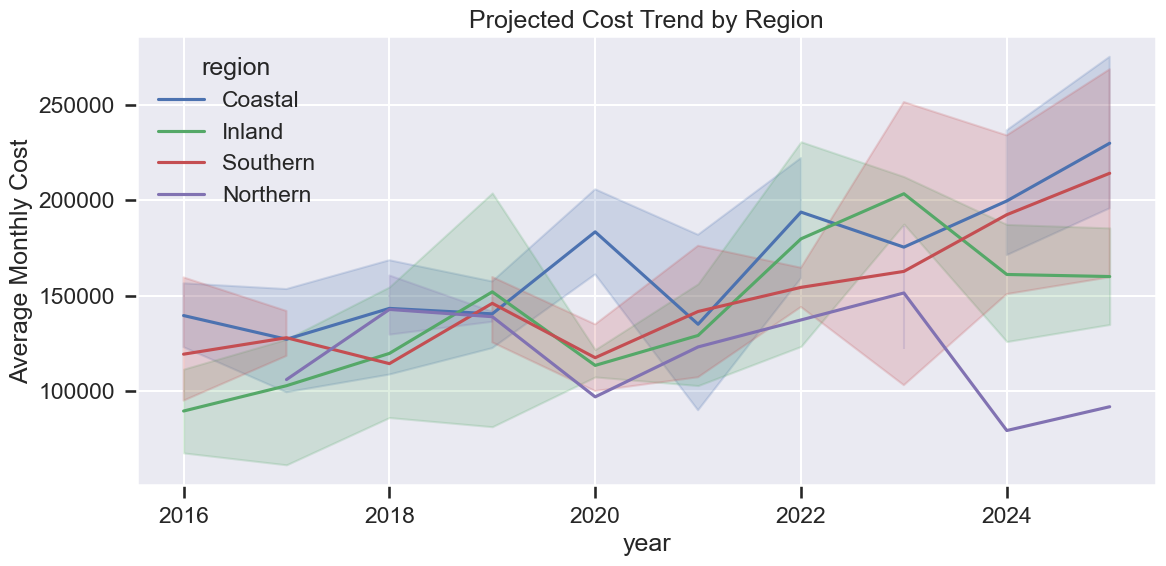

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="year", y="projected_cost", hue="region", estimator='mean')
plt.title("Projected Cost Trend by Region")
plt.ylabel("Average Monthly Cost")
plt.tight_layout()
plt.show()

## 3. Model monthly projected cost

In [5]:
features = pd.get_dummies(df.drop(columns=["projected_cost"]), columns=["region"], drop_first=True)
target = df["projected_cost"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=303
)

model = GradientBoostingRegressor(random_state=303, n_estimators=400, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R^2 : {r2:.3f}")

RMSE: 23,707
MAE: 20,291
R^2 : 0.754


/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_56041/2289202567.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values[:12], y=feature_importance.index[:12], orient='h', palette='coolwarm')


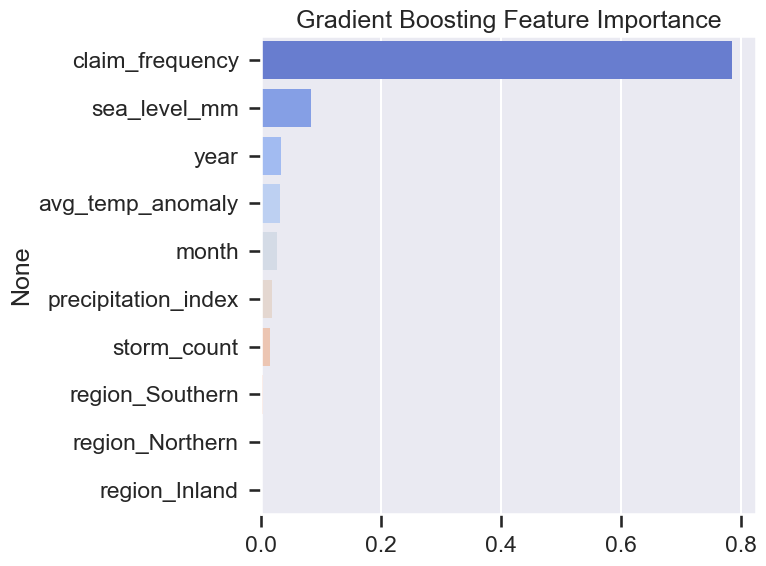

In [6]:
feature_importance = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance.values[:12], y=feature_importance.index[:12], orient='h', palette='coolwarm')
plt.title("Gradient Boosting Feature Importance")
plt.tight_layout()
plt.show()

## 4. Forward-looking projection

In [7]:
future_years = np.repeat(np.arange(2026, 2029), 12)
future_months = np.tile(np.arange(1, 13), len(future_years) // 12)
future_regions = np.repeat(["Coastal", "Inland", "Northern", "Southern"], len(future_years) // 4)
future_regions = future_regions[:len(future_years)]

future_df = pd.DataFrame(
    {
        "year": future_years,
        "month": future_months,
        "region": future_regions,
        "storm_count": rng.poisson(3 + 0.08 * (future_years - 2016)),
        "avg_temp_anomaly": rng.normal(1.1 + 0.035 * (future_years - 2016), 0.2),
        "precipitation_index": rng.normal(1.05, 0.15),
        "sea_level_mm": rng.normal(60 + 3.5 * (future_years - 2016), 5),
        "claim_frequency": rng.normal(6.5, 1.2)
    }
)

future_encoded = pd.get_dummies(future_df, columns=["region"], drop_first=True)
predicted_cost = model.predict(future_encoded)
future_df["projected_cost"] = predicted_cost

future_summary = future_df.groupby("year")["projected_cost"].mean().reset_index()
future_summary

,year,projected_cost
0,2026,130889.867783
1,2027,118221.482027
2,2028,114011.523077
